In [ ]:
# Импорты
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import optuna

In [2]:
# Загрузка данных
df = pd.read_csv('../data/raw/UCI_Credit_Card.csv', delimiter=',')
print(f"Строк: {df.shape[0]}, столбцов: {df.shape[1]}")

Строк: 30000, столбцов: 25


In [ ]:
# Выведем первые строки
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [3]:
# Проверим типы данных
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [4]:
# Проверим пропуски
print(df.isna().sum())

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64


Пропуски отсутствуют

In [3]:
# Переименуем PAY_0 в PAY_1 для удобства
df.rename(columns={'PAY_0':'PAY_1', 'default.payment.next.month':'def_pay'}, inplace=True)

In [4]:
# Удалим ненужную колонку
df.drop(columns=['ID'], inplace=True)

In [6]:
# Конвертируем категориальные признаки
cat_cols = ['SEX','EDUCATION','MARRIAGE','PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']
for col in cat_cols:
    df[col] = df[col].astype('category')

df['def_pay'] = df['def_pay'].astype('category')

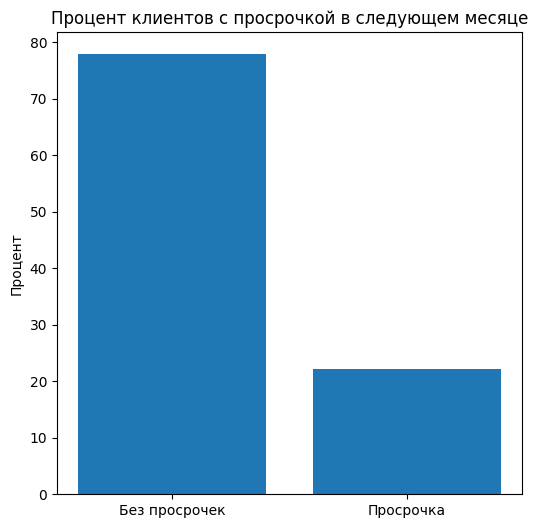

In [7]:
# Распределение целевой переменной
def_cnt = df.def_pay.value_counts(normalize=True) * 100
plt.figure(figsize=(6,6))
plt.bar(def_cnt.index, def_cnt.values)
plt.xticks([0,1], ['Без просрочек', 'Просрочка'])
plt.title("Процент клиентов с просрочкой в следующем месяце")
plt.ylabel("Процент")
plt.show()

Судя по графику от 77% клиентов не ожидается просрочка платежа, и от 23% клиентов ожидается.

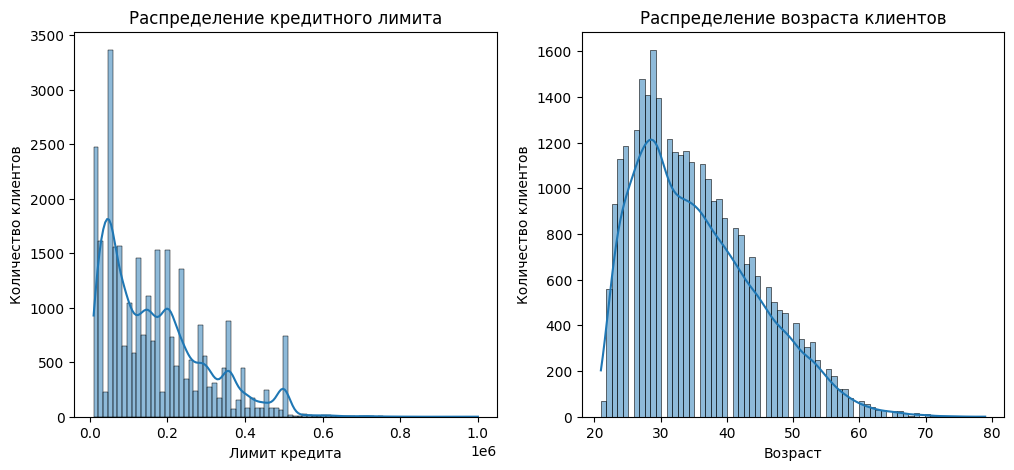

In [8]:
# Распределение кредитного лимита и возраста
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(df['LIMIT_BAL'], kde=True)
plt.title("Распределение кредитного лимита")
plt.xlabel("Лимит кредита")
plt.ylabel("Количество клиентов")

plt.subplot(1,2,2)
sns.histplot(df['AGE'], kde=True)
plt.title("Распределение возраста клиентов")
plt.xlabel("Возраст")
plt.ylabel("Количество клиентов")
plt.show()

При визуализации непрерывных признаков, мы видим, что распределение кредитного лимита и возраста клиентов смещённое. Большинство клиентов имеют кредитный лимит в диапазоне от 0 до 200 000. Также большинство клиентов находятся в возрастной группе от 20 до 40 лет, то есть это в основном молодые и средние по возрасту клиенты.

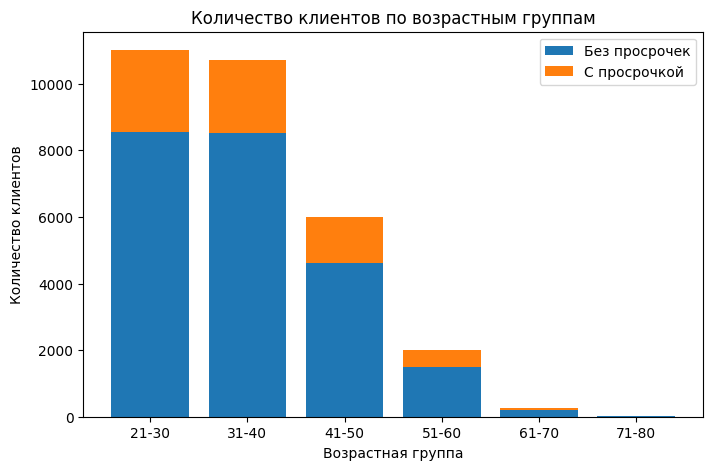

In [9]:
bins = [20,30,40,50,60,70,80]
labels = ['21-30','31-40','41-50','51-60','61-70','71-80']
age_bin = pd.cut(df.AGE, bins=bins, labels=labels, right=True)

# Визуализация количества клиентов по возрастным группам
age_0 = age_bin[df['def_pay']==0].value_counts()
age_1 = age_bin[df['def_pay']==1].value_counts()

plt.figure(figsize=(8,5))
plt.bar(age_0.index, age_0.values, label='Без просрочек')
plt.bar(age_1.index, age_1.values, label='С просрочкой', bottom=age_0.values)
plt.title("Количество клиентов по возрастным группам")
plt.ylabel("Количество клиентов")
plt.xlabel("Возрастная группа")
plt.legend()
plt.show()

Наибольшее количество клиентов приходится на возрастную группу 21–30 лет, за ней следует группа 31–40 лет. При увеличении возрастной группы число клиентов, которые могут допустить просрочку платежа в следующем месяце уменьшается. Таким образом, возраст является важным признаком для прогнозирования просрочки в следующем месяце.

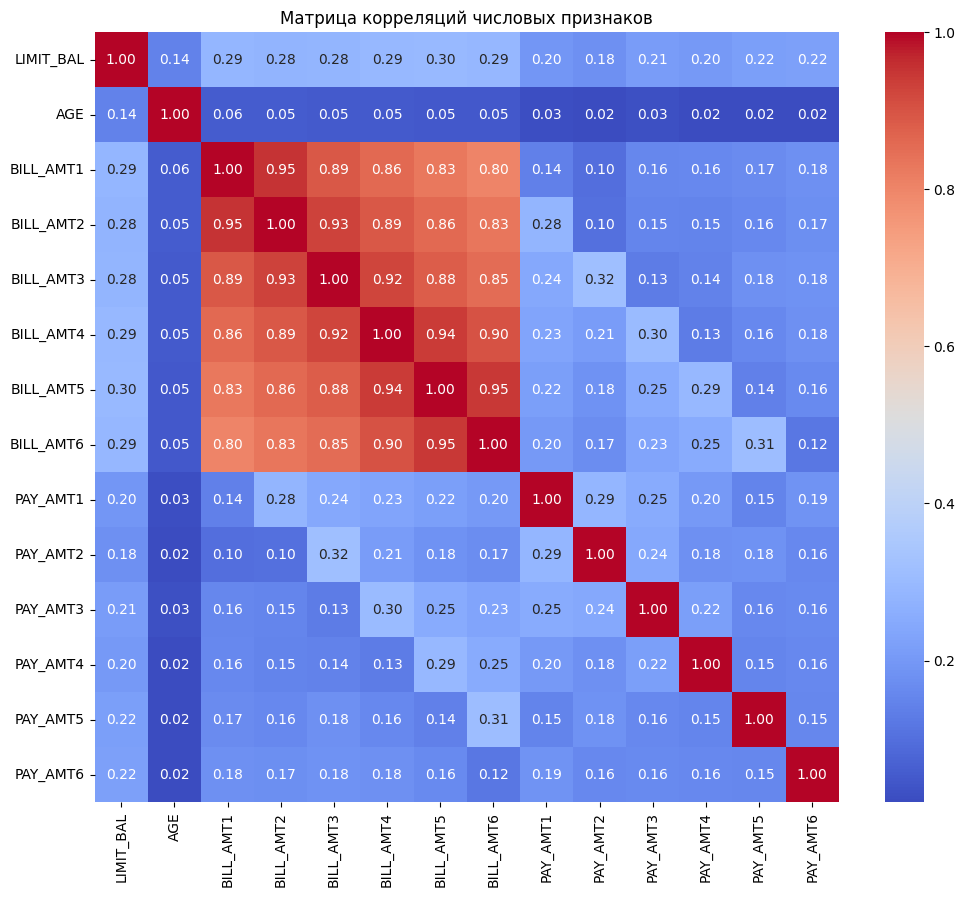

Пары высоко коррелированных признаков:
('BILL_AMT2', 'BILL_AMT1', 0.9514836727518136)
('BILL_AMT3', 'BILL_AMT1', 0.8922785291271761)
('BILL_AMT3', 'BILL_AMT2', 0.9283262592714855)
('BILL_AMT4', 'BILL_AMT1', 0.8602721890293095)
('BILL_AMT4', 'BILL_AMT2', 0.8924822912577209)
('BILL_AMT4', 'BILL_AMT3', 0.9239694565909823)
('BILL_AMT5', 'BILL_AMT1', 0.8297786058330013)
('BILL_AMT5', 'BILL_AMT2', 0.859778307271445)
('BILL_AMT5', 'BILL_AMT3', 0.8839096973620155)
('BILL_AMT5', 'BILL_AMT4', 0.9401344040880004)
('BILL_AMT6', 'BILL_AMT1', 0.8026501885528455)
('BILL_AMT6', 'BILL_AMT2', 0.8315935591018213)
('BILL_AMT6', 'BILL_AMT3', 0.8533200905940468)
('BILL_AMT6', 'BILL_AMT4', 0.9009409547978421)
('BILL_AMT6', 'BILL_AMT5', 0.9461968070521957)


In [ ]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Вычисляем корреляцию
corr_matrix = numeric_df.corr()

# Строим тепловую карту
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Матрица корреляций числовых признаков")
plt.show()

# Находим пары признаков с высокой корреляцией
threshold = 0.8
high_corr = []

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

print("Пары высоко коррелированных признаков:")
for pair in high_corr:
    print(pair)

In [ ]:
# Разделяем данные на train и test
df_X = df.drop(columns=['def_pay'])
df_y = df['def_pay']
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=42)

In [12]:
# Определяем стратегии работы с мультиколлинеарными признаками BILL_AMT
strategies = {}

# Вариант 1: оставить только BILL_AMT1
X1 = X_train.drop(columns=['BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6'])
X1_test = X_test.drop(columns=['BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6'])
strategies['one_column'] = (X1, X1_test)

# Вариант 2: использовать все BILL_AMT
strategies['all_columns'] = (X_train, X_test)

# Вариант 3: агрегированные признаки (сумма, среднее, максимум)
def add_agg_features(df):
    df = df.copy()
    df['BILL_AMT_SUM'] = df[['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']].sum(axis=1)
    df['BILL_AMT_MEAN'] = df[['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']].mean(axis=1)
    df['BILL_AMT_MAX'] = df[['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']].max(axis=1)
    return df.drop(columns=['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6'])

X3_train = add_agg_features(X_train)
X3_test = add_agg_features(X_test)
strategies['aggregated'] = (X3_train, X3_test)

# Обучение и оценка модели для каждой стратегии
results = {}

for name, (X_tr, X_te) in strategies.items():
    model = XGBClassifier(eval_metric='logloss', random_state=42, enable_categorical=True)
    model.fit(X_tr, y_train)
    y_pred_proba = model.predict_proba(X_te)[:,1]
    auc = roc_auc_score(y_test, y_pred_proba)
    results[name] = auc
    print(f"Стратегия {name}: ROC-AUC = {auc:.4f}")

# Выбор лучшей стратегии
best_strategy = max(results, key=results.get)
print(f"Лучшая стратегия: {best_strategy} с ROC-AUC = {results[best_strategy]:.4f}")

Стратегия one_column: ROC-AUC = 0.7654
Стратегия all_columns: ROC-AUC = 0.7691
Стратегия aggregated: ROC-AUC = 0.7620
Лучшая стратегия: all_columns с ROC-AUC = 0.7691


Судя по тестам, лучшим решением будет оставить все столбцы.

In [ ]:
# Определяем числовые и категориальные признаки
numeric_features = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 
                   'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 
                   'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

categorical_features = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 
                       'PAY_4', 'PAY_5', 'PAY_6']

# Создаем пайплайны с StandardScaler для числовых признаков
models = {
    'XGBClassifier': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', XGBClassifier(eval_metric='logloss', random_state=42))
    ]),
    'RandomForest': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(random_state=42))
    ]),
    'GradientBoosting': Pipeline([
        ('scaler', StandardScaler()), 
        ('classifier', GradientBoostingClassifier(random_state=42))
    ]),
    'ExtraTrees': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', ExtraTreesClassifier(random_state=42))
    ])
}

results = {}
for name, pipeline in models.items():
    # Применяем пайплайн только к числовым признакам
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    
    scaler = StandardScaler()
    X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])
    X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])
    
    # Обучаем модель
    pipeline.fit(X_train_scaled, y_train)
    y_pred_proba = pipeline.predict_proba(X_test_scaled)[:,1]
    auc = roc_auc_score(y_test, y_pred_proba)
    results[name] = auc
    print(f"{name}: ROC-AUC = {auc:.4f}")

best_model_name = max(results, key=results.get)
print(f"Лучшая модель: {best_model_name} с ROC-AUC = {results[best_model_name]:.4f}")

XGBClassifier: ROC-AUC = 0.7750
RandomForest: ROC-AUC = 0.7570
GradientBoosting: ROC-AUC = 0.7828
ExtraTrees: ROC-AUC = 0.7475
Лучшая модель: GradientBoosting с ROC-AUC = 0.7828


Определим наилучшие параметры для GradientBoosting

In [ ]:
# Определяем признаки
numeric_features = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 
                   'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 
                   'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

categorical_features = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_1', 'PAY_2', 'PAY_3', 
                       'PAY_4', 'PAY_5', 'PAY_6']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', 'passthrough', categorical_features)
    ]
)

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    }
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', GradientBoostingClassifier(**params, random_state=42))
    ])
    
    # Обучаем и оцениваем
    pipeline.fit(X_train, y_train)
    y_pred_proba = pipeline.predict_proba(X_test)[:,1]
    return roc_auc_score(y_test, y_pred_proba)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print(f"Лучшие параметры: {study.best_params}")
print(f"Лучший ROC-AUC: {study.best_value:.4f}")

best_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(**study.best_params, random_state=42))
])

best_pipeline.fit(X_train, y_train)
final_auc = roc_auc_score(y_test, best_pipeline.predict_proba(X_test)[:,1])
print(f"Финальный ROC-AUC с лучшими параметрами: {final_auc:.4f}")

[I 2025-11-03 00:49:05,965] A new study created in memory with name: no-name-0907e6e0-e495-45e9-89f2-306b2dd47d64
[I 2025-11-03 00:49:11,336] Trial 0 finished with value: 0.778911334700784 and parameters: {'n_estimators': 226, 'learning_rate': 0.10715209739011138, 'max_depth': 5, 'min_samples_split': 15, 'min_samples_leaf': 9, 'subsample': 0.9327298720598719, 'max_features': 'log2'}. Best is trial 0 with value: 0.778911334700784.
[I 2025-11-03 00:49:13,017] Trial 1 finished with value: 0.7777215454390789 and parameters: {'n_estimators': 113, 'learning_rate': 0.1764996132759915, 'max_depth': 4, 'min_samples_split': 16, 'min_samples_leaf': 3, 'subsample': 0.6374268739906451, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.778911334700784.
[I 2025-11-03 00:49:18,022] Trial 2 finished with value: 0.7804168519788087 and parameters: {'n_estimators': 132, 'learning_rate': 0.054294047383515696, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 9, 'subsample': 0.914188775025458

Лучшие параметры: {'n_estimators': 175, 'learning_rate': 0.03834279478157687, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 3, 'subsample': 0.6796169854953065, 'max_features': None}
Лучший ROC-AUC: 0.7853
Финальный ROC-AUC с лучшими параметрами: 0.7853
